[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mifumo081a/pytorch_template/blob/main/examples/notebooks/mnist.ipynb)


In [1]:
!git clone https://github.com/mifumo081a/pytorch_template.git
!ls

Cloning into 'pytorch_template'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 95 (delta 32), reused 84 (delta 22), pack-reused 0
Unpacking objects: 100% (95/95), done.
pytorch_template  sample_data


In [2]:
!pip install -r pytorch_template/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
import os
import torchinfo

In [4]:
root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN =True

In [5]:
logs_root = os.path.join(root, "logs/", "mnist/")
os.makedirs(logs_root, exist_ok=True)

In [6]:
trainval_dataset = datasets.MNIST(os.path.join(root, "data/"), train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(os.path.join(root, "data/"), train=False, download=True, transform=transforms.ToTensor())

trainval_dataset.labels = [str(i) for i in range(10)]
test_dataset.labels  = [str(i) for i in range(10)]

transforms_dict = {"train": 
                   transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "val":
                    transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "test":
                   transforms.Compose([
                       transforms.ToTensor()
                       ])
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [7]:
import pytorch_template.cross_varidation as cv

In [8]:
num_workers = os.cpu_count()
n_splits = 5
batch_size = 50
if TRAIN:
    kfold_root = cv.kfold_split(dataset=trainval_dataset, test_dataset=test_dataset, transforms=transforms_dict, n_splits=n_splits,
                                root=root, num_workers=num_workers, batch_size=batch_size,
                                shuffle=True, random_state=0)
else:
    os.path.join(root, "kfold_pickle")
print(kfold_root)

Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Test: 10000
All: 70000
/content/kfold_pickle


# Model initialize and Train

In [9]:
from pytorch_template.models import *

In [10]:
class Model(GradCAM_Model):
    def __init__(self):
        super().__init__()
        self.features = torchvision.models.vgg16(pretrained=True).features[:10]
        for layer in self.features:
            for param in layer.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )
        
    def get_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        return self.features(x)
    
    def get_outputs(self, x):
        x = x.mean([2, 3])
        return self.classifier(x)
        
    def forward(self,x):
        x = self.get_features(x)
        x = self.get_outputs(x)
        return x

torchinfo.summary(Model(), (1, 1, 28, 28))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-10                   [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 10]             

In [11]:
from pytorch_template.utils import get_dataloaders, get_testloaders, get_model, set_model
from pytorch_template.trainer import Trainer_Classifier

In [12]:
model_root = os.path.join(root, "models/")
print(model_root)
if TRAIN:
    set_model(model=Model(), model_root=model_root)

/content/models/


In [13]:
if TRAIN:
  trainer_list = []
  for k in range(n_splits):
    path = os.path.join(kfold_root, str(k)+"/")
    print(path)
    trainer = Trainer_Classifier(model=get_model("nontrain", model_root, device),
                                 device=device, dataloaders=get_dataloaders(path),
                                 epochs=10, lr=1e-3)
    trainer_list.append(trainer)

/content/kfold_pickle/0/
/content/models/nontrain.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/1/
/content/models/nontrain.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/2/
/content/models/nontrain.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/3/
/content/models/nontrain.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/4/
/content/models/nontrain.pkl
/content/kfold_pickle/4/dataloaders.pkl


In [14]:
if TRAIN:
    cv.kfold_train(save_model_root=model_root, n_splits=n_splits,
                   trainer_list=trainer_list)

Pattern:  0


[Epoch10/10]: 100%|██████████| 10/10 [01:33<00:00,  9.40s/it, Loss=1.61, Acc=0.924]


Best val Loss: 1.6105
Acc: 0.9243 
Pattern:  1


[Epoch10/10]: 100%|██████████| 10/10 [01:36<00:00,  9.62s/it, Loss=1.62, Acc=0.914]


Best val Loss: 1.6183
Acc: 0.9145 
Pattern:  2


[Epoch10/10]: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it, Loss=1.61, Acc=0.923]


Best val Loss: 1.6095
Acc: 0.9230 
Pattern:  3


[Epoch10/10]: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it, Loss=1.61, Acc=0.926]


Best val Loss: 1.6112
Acc: 0.9257 
Pattern:  4


[Epoch10/10]: 100%|██████████| 10/10 [01:33<00:00,  9.40s/it, Loss=1.61, Acc=0.928]

Best val Loss: 1.6077
Acc: 0.9283 


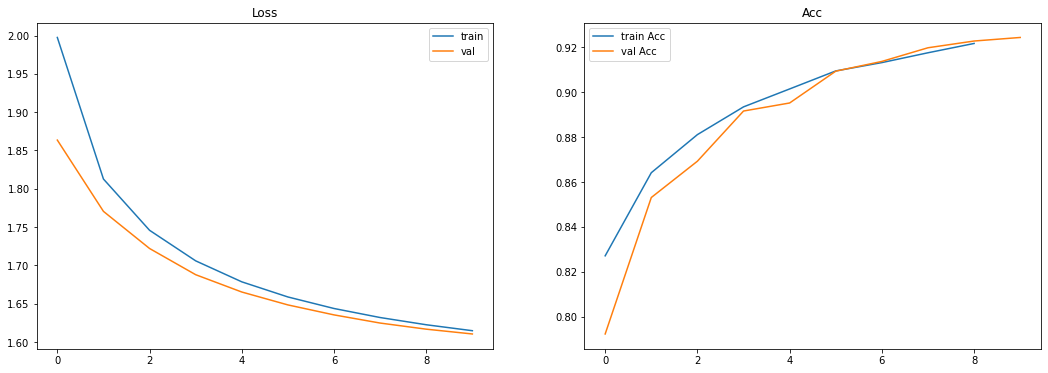

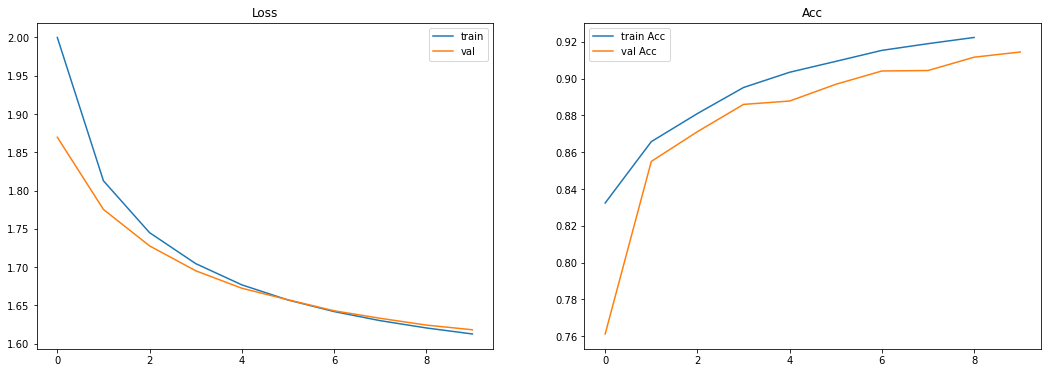

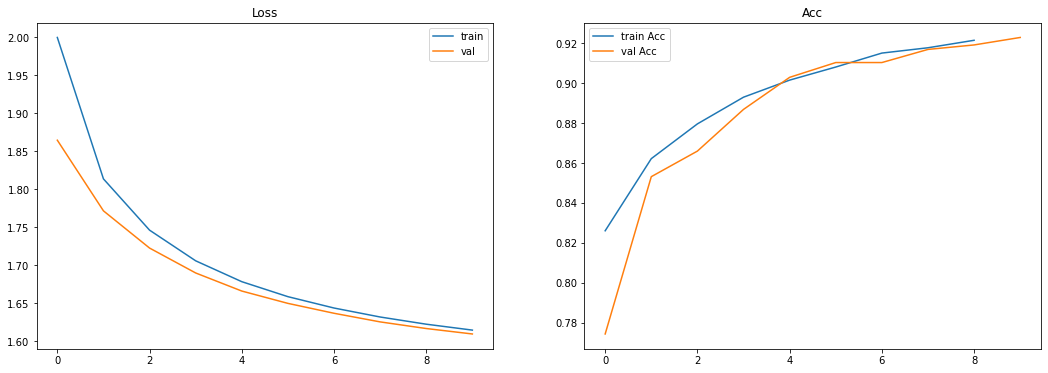

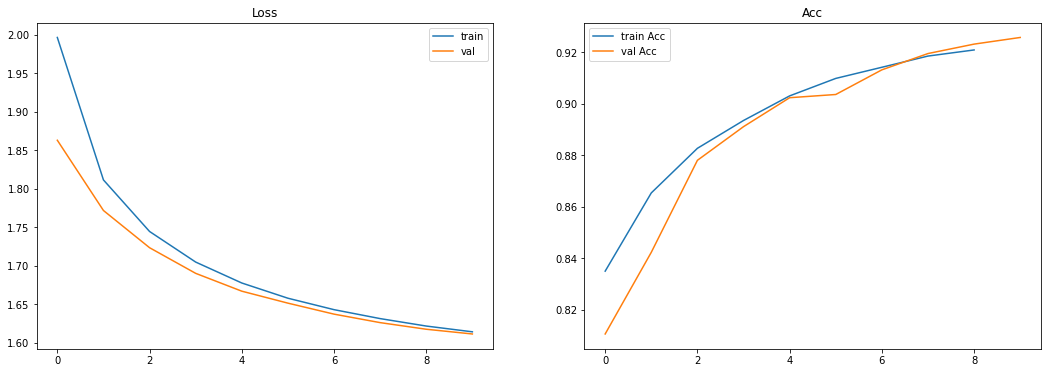

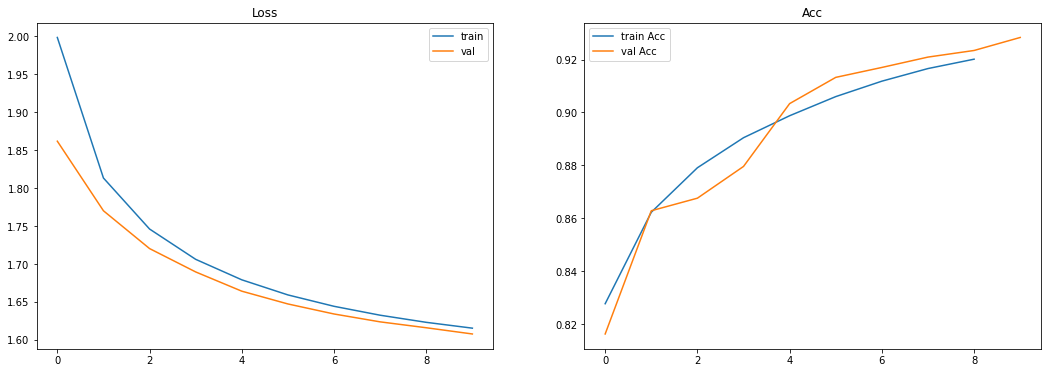

In [15]:
if TRAIN:
    for k in range(n_splits):
        path = os.path.join(kfold_root, str(k)+"/")
        trainer_list[k].show_curve(logs_root=os.path.join
                                   (logs_root, "curves/"), fname=str(k), save=False)

# Evaluate models

In [16]:
from pytorch_template.evaluator import ImageClassifier_Evaluator

In [17]:
evaluator_list = []
for k in range(n_splits):
    dataloader_path = os.path.join(kfold_root, str(k)+"/")
    model_path = os.path.join(model_root, str(k)+"/")
    print(dataloader_path, model_path)
    evaluator_list.append(ImageClassifier_Evaluator(model=get_model("model_fit", model_path, device),
                                          device=device,
                                          dataloaders=get_dataloaders(dataloader_path),
                                          testloaders=get_testloaders(kfold_root),
                                          logs_root=logs_root
                                         )
                         )

/content/kfold_pickle/0/ /content/models/0/
/content/models/0/model_fit.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/1/ /content/models/1/
/content/models/1/model_fit.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/2/ /content/models/2/
/content/models/2/model_fit.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/3/ /content/models/3/
/content/models/3/model_fit.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/4/ /content/models/4/
/content/models/4/model_fit.pkl
/content/kfold_pickle/4/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.99      0.99      0.99      1135
           2       0.90      0.85      0.88      1032
           3       0.94      0.94      0.94      1010
           4       0.93      0.95      0.94       982
           5       0.85      0.90      0.88       892
           6       0.97      0.90      0.93       958
           7       0.94      0.93      0.94      1028
           8       0.88      0.96      0.92       974
           9       0.93      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



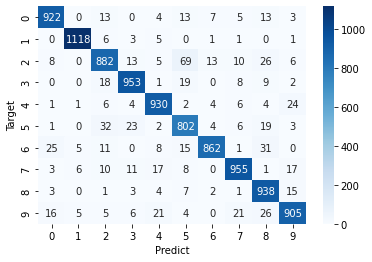

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.85      0.87      0.86      1032
           3       0.96      0.92      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.82      0.92      0.87       892
           6       0.97      0.90      0.93       958
           7       0.94      0.93      0.93      1028
           8       0.93      0.95      0.94       974
           9       0.95      0.87      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



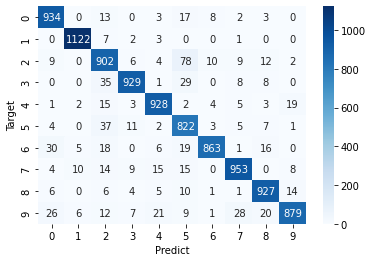

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.99      0.98      0.99      1135
           2       0.88      0.87      0.87      1032
           3       0.95      0.93      0.94      1010
           4       0.89      0.96      0.93       982
           5       0.85      0.91      0.88       892
           6       0.95      0.92      0.93       958
           7       0.94      0.92      0.93      1028
           8       0.94      0.94      0.94       974
           9       0.93      0.88      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



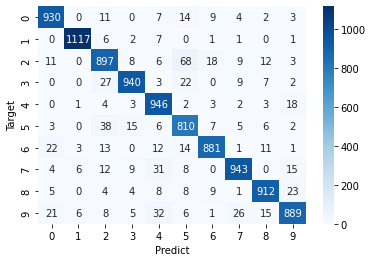

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.87      0.87      0.87      1032
           3       0.95      0.93      0.94      1010
           4       0.94      0.94      0.94       982
           5       0.85      0.91      0.88       892
           6       0.96      0.91      0.93       958
           7       0.95      0.92      0.93      1028
           8       0.91      0.96      0.93       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



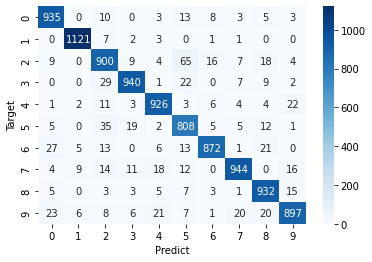

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.99      0.99      0.99      1135
           2       0.87      0.88      0.88      1032
           3       0.94      0.95      0.94      1010
           4       0.93      0.95      0.94       982
           5       0.85      0.91      0.88       892
           6       0.96      0.91      0.93       958
           7       0.96      0.91      0.93      1028
           8       0.94      0.94      0.94       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



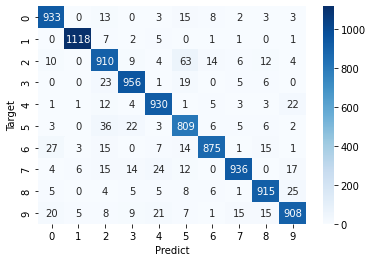

In [18]:
kfold_acc = []
for k in range(n_splits):
    evaluator_list[k].confusion_matrix(folder_name="confusion_matrix", fname=str(k), save=False)
    kfold_acc.append(evaluator_list[k].acc)

In [19]:
print("Acc mean: {:.4f}, std: {:.4f}".format(np.array(kfold_acc).mean(), np.array(kfold_acc).std()))

Acc mean: 0.9271, std: 0.0011


In [20]:
for k in range(n_splits):
    evaluator_list[k].show_scores(folder_name="eval", fname=str(k), save=False)

Accuracy: 0.9267
F scores: (0: 0.9413)(1: 0.9850)(2: 0.8750)(3: 0.9408)(4: 0.9399)(5: 0.8760)(6: 0.9314)(7: 0.9354)(8: 0.9192)(9: 0.9118)
Recalls: (0: 0.9408)(1: 0.9850)(2: 0.8547)(3: 0.9436)(4: 0.9470)(5: 0.8991)(6: 0.8998)(7: 0.9290)(8: 0.9630)(9: 0.8969)
Precisions: (0: 0.9418)(1: 0.9850)(2: 0.8963)(3: 0.9380)(4: 0.9328)(5: 0.8541)(6: 0.9653)(7: 0.9418)(8: 0.8791)(9: 0.9273)
Accuracy: 0.9259
F scores: (0: 0.9368)(1: 0.9842)(2: 0.8627)(3: 0.9379)(4: 0.9421)(5: 0.8685)(6: 0.9340)(7: 0.9339)(8: 0.9411)(9: 0.9099)
Recalls: (0: 0.9531)(1: 0.9885)(2: 0.8740)(3: 0.9198)(4: 0.9450)(5: 0.9215)(6: 0.9008)(7: 0.9270)(8: 0.9517)(9: 0.8712)
Precisions: (0: 0.9211)(1: 0.9799)(2: 0.8517)(3: 0.9567)(4: 0.9393)(5: 0.8212)(6: 0.9697)(7: 0.9408)(8: 0.9307)(9: 0.9523)
Accuracy: 0.9265
F scores: (0: 0.9413)(1: 0.9850)(2: 0.8743)(3: 0.9419)(4: 0.9275)(5: 0.8785)(6: 0.9338)(7: 0.9295)(8: 0.9392)(9: 0.9044)
Recalls: (0: 0.9490)(1: 0.9841)(2: 0.8692)(3: 0.9307)(4: 0.9633)(5: 0.9081)(6: 0.9196)(7: 0.9173)(8:

In [21]:
for k in range(n_splits):
    evaluator_list[k].show_cam(folder_name="cam", fname=str(k), save=False)

RuntimeError: ignored